<a href="https://colab.research.google.com/github/PinkOrangeSapphire/229352/blob/main/Lab02_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [133]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [134]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [135]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [136]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y_new'] = df['y'].map({'no': 0, 'yes': 1})

In [137]:
# Drop 'duration' due to data leakage
df = df.drop("duration", axis=1)

In [138]:
# Define features (X) and target (y)
X = df.drop(['y','y_new'], axis=1)
y = df['y_new']

In [139]:
# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Print data shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (28831, 14)
X_test shape: (12357, 14)
y_train shape: (28831,)
y_test shape: (12357,)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [140]:
num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data

X_train[num_cols_demo] = scaler.fit_transform(X_train[num_cols_demo])

X_test[num_cols_demo] = scaler.transform(X_test[num_cols_demo])

X_train[num_cols_demo]


,age,campaign
9438,-0.770903,0.508165
21904,0.379511,-0.559789
10546,1.338190,-0.559789
8092,0.283643,-0.203804
7298,1.146454,1.576119
...,...,...
23923,0.379511,0.152180
35814,-0.866771,0.508165
40202,-1.058507,0.152180
9354,0.091908,-0.203804


In [141]:
X_train.describe()

,age,campaign,pdays,previous
count,2.883100e+04,2.883100e+04,28831.000000,28831.000000
mean,-2.518729e-16,6.087338e-17,962.252992,0.175748
std,1.000017e+00,1.000017e+00,187.452736,0.497600
min,-2.208922e+00,-5.597891e-01,0.000000,0.000000
25%,-7.709034e-01,-5.597891e-01,999.000000,0.000000
50%,-1.956961e-01,-2.038044e-01,999.000000,0.000000
75%,6.671149e-01,1.521803e-01,999.000000,0.000000
max,5.556377e+00,1.901937e+01,999.000000,7.000000


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [142]:
ord_col_demo = ['education']

imputer_ord = SimpleImputer(strategy='most_frequent')

## Write your code here

X_train[ord_col_demo] = imputer_ord.fit_transform(X_train[ord_col_demo])
X_test[ord_col_demo] = imputer_ord.transform(X_test[ord_col_demo])

X_train[ord_col_demo]


,education
9438,university.degree
21904,professional.course
10546,university.degree
8092,high.school
7298,basic.9y
...,...
23923,professional.course
35814,university.degree
40202,university.degree
9354,university.degree


- **Ordinal Encoding**

In [143]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [144]:
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

## Write your code here
X_train[ord_col_demo] = ordinal_encoder.fit_transform(X_train[ord_col_demo])
X_test[ord_col_demo] = ordinal_encoder.transform(X_test[ord_col_demo])

X_train[ord_col_demo]




,education
9438,6.0
21904,5.0
10546,6.0
8092,4.0
7298,3.0
...,...
23923,5.0
35814,6.0
40202,6.0
9354,6.0


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [145]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [146]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Write your code here

X_train_onehot_encoded_demo = onehot_encoder.fit_transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

X_train_onehot_encoded_demo

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [147]:
X_train = pd.concat([X_train.reset_index(drop=True),
                              pd.DataFrame(X_train_onehot_encoded_demo, columns = onehot_encoder.get_feature_names_out(['job']))], axis=1)

X_test = pd.concat([X_test.reset_index(drop=True),
                              pd.DataFrame(X_test_onehot_encoded_demo, columns = onehot_encoder.get_feature_names_out(['job']))], axis=1)

In [148]:
# drop job
X_train = X_train.drop(['job'], axis=1)
X_test = X_test.drop(['job'], axis=1)

# drop job_services
X_train = X_train.drop(['job_services'], axis=1)
X_test = X_test.drop(['job_services'], axis=1)

In [149]:
X_train

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed
0,-0.770903,single,6.0,no,NaN,NaN,telephone,jun,fri,0.508165,999,0,nonexistent,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.379511,single,5.0,no,yes,no,cellular,aug,wed,-0.559789,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.338190,married,6.0,no,no,no,telephone,jun,tue,-0.559789,999,0,nonexistent,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.283643,married,4.0,NaN,no,no,telephone,jun,mon,-0.203804,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.146454,married,3.0,NaN,no,no,telephone,may,thu,1.576119,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,0.379511,single,5.0,no,yes,no,cellular,aug,fri,0.152180,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28827,-0.866771,married,6.0,no,yes,no,telephone,may,mon,0.508165,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28828,-1.058507,married,6.0,no,yes,no,cellular,jul,mon,0.152180,999,0,nonexistent,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28829,0.091908,married,6.0,no,yes,no,telephone,jun,fri,-0.203804,999,0,nonexistent,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [150]:
X_test

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed
0,-0.483300,married,5.0,no,yes,no,cellular,apr,thu,-0.203804,6,1,success,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.003960,single,3.0,no,yes,no,cellular,jul,mon,-0.559789,999,0,nonexistent,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.483300,single,6.0,no,no,no,telephone,may,thu,0.864150,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.146454,divorced,6.0,no,no,no,telephone,jun,mon,0.152180,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.770903,single,2.0,NaN,NaN,NaN,cellular,jul,tue,0.508165,999,0,nonexistent,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12352,-0.099828,married,6.0,no,yes,no,cellular,jul,thu,-0.559789,999,0,nonexistent,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12353,-0.770903,single,3.0,no,yes,no,cellular,jul,wed,6.203921,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12354,1.625794,married,3.0,no,no,no,cellular,aug,tue,0.508165,999,0,nonexistent,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12355,-0.483300,married,6.0,no,yes,no,cellular,may,fri,-0.559789,999,0,nonexistent,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [151]:
# Define feature lists ---

# Based on the variable table and previous operations
numerical_features = ['age', 'campaign', 'pdays', 'previous']

ordinal_features = ['education']
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

binary_features = ['housing', 'loan', 'contact'] # 'default' will be dropped

# Exclude 'default' as it will be dropped
nominal_features = ['job', 'marital', 'month', 'day_of_week', 'poutcome']

In [152]:
# imputaition missing value
nom_col_demo1 = ['marital']

imputer_nom1 = SimpleImputer(strategy='most_frequent')
imputer_nom1.fit(X_train[nom_col_demo1])

X_train_imputed_nom_demo1 = imputer_nom1.fit_transform(X_train[nom_col_demo1])
X_test_imputed_nom_demo1 = imputer_nom1.transform(X_test[nom_col_demo1])

pd.Series(X_train_imputed_nom_demo1.flatten()).value_counts()


,count
married,17571
single,8062
divorced,3198


In [153]:
# Nominal Encoding
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Write your code here
X_train_onehot_encoded_demo1 = onehot_encoder.fit_transform(X_train_imputed_nom_demo1)
X_test_onehot_encoded_demo1 = onehot_encoder.transform(X_test_imputed_nom_demo1)

X_train_onehot_encoded_demo1

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [154]:
X_train = pd.concat([X_train.reset_index(drop=True),
                              pd.DataFrame(X_train_onehot_encoded_demo1, columns = onehot_encoder.get_feature_names_out(['marital']))], axis=1)

X_test = pd.concat([X_test.reset_index(drop=True),
                              pd.DataFrame(X_test_onehot_encoded_demo1, columns = onehot_encoder.get_feature_names_out(['marital']))], axis=1)


In [155]:
# drop jmarital
X_train = X_train.drop(['marital'], axis=1)
X_test = X_test.drop(['marital'], axis=1)
# Drop marital_divorced to prevent the dummy variable trap.
X_train = X_train.drop(['marital_divorced'], axis=1)
X_test = X_test.drop(['marital_divorced'], axis=1)

In [156]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [157]:
X_train_copy[['day_of_week', 'month', 'poutcome']].isnull().sum()

,0
day_of_week,0
month,0
poutcome,0


In [158]:
#dummy apply Train
X_train_copy = pd.get_dummies(
    X_train_copy,
    columns=['day_of_week', 'month', 'poutcome'],
    drop_first=True)
#dummy apply Test
X_test_copy = pd.get_dummies(
    X_test_copy,
    columns=['day_of_week', 'month', 'poutcome'],
    drop_first=True)

In [159]:
X_train_copy

,age,education,default,housing,loan,contact,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed,marital_married,marital_single,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,-0.770903,6.0,no,NaN,NaN,telephone,0.508165,999,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
1,0.379511,5.0,no,yes,no,cellular,-0.559789,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
2,1.338190,6.0,no,no,no,telephone,-0.559789,999,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
3,0.283643,4.0,NaN,no,no,telephone,-0.203804,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,1.146454,3.0,NaN,no,no,telephone,1.576119,999,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,0.379511,5.0,no,yes,no,cellular,0.152180,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
28827,-0.866771,6.0,no,yes,no,telephone,0.508165,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False
28828,-1.058507,6.0,no,yes,no,cellular,0.152180,999,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
28829,0.091908,6.0,no,yes,no,telephone,-0.203804,999,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False


In [160]:
X_test_copy

,age,education,default,housing,loan,contact,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed,marital_married,marital_single,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,-0.483300,5.0,no,yes,no,cellular,-0.203804,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,-0.003960,3.0,no,yes,no,cellular,-0.559789,999,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,-0.483300,6.0,no,no,no,telephone,0.864150,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False
3,1.146454,6.0,no,no,no,telephone,0.152180,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,-0.770903,2.0,NaN,NaN,NaN,cellular,0.508165,999,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12352,-0.099828,6.0,no,yes,no,cellular,-0.559789,999,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False
12353,-0.770903,3.0,no,yes,no,cellular,6.203921,999,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
12354,1.625794,3.0,no,no,no,cellular,0.508165,999,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False
12355,-0.483300,6.0,no,yes,no,cellular,-0.559789,999,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [161]:
num_cols_demo = ['pdays','previous']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data

X_train_copy[num_cols_demo] = scaler.fit_transform(X_train_copy[num_cols_demo])

X_test_copy[num_cols_demo] = scaler.transform(X_test_copy[num_cols_demo])

X_train_copy[num_cols_demo]

,pdays,previous
0,0.196037,-0.353198
1,0.196037,-0.353198
2,0.196037,-0.353198
3,0.196037,-0.353198
4,0.196037,-0.353198
...,...,...
28826,0.196037,-0.353198
28827,0.196037,-0.353198
28828,0.196037,-0.353198
28829,0.196037,-0.353198


In [162]:
binary_cols = ['default', 'housing', 'loan','contact']
X_train_copy[binary_cols].isnull().sum()

,0
default,5988
housing,658
loan,658
contact,0


In [163]:
for col in binary_cols:
    print(X_train_copy[col].value_counts(), "\n")

default
no     22841
yes        2
Name: count, dtype: int64 

housing
yes    15091
no     13082
Name: count, dtype: int64 

loan
no     23761
yes     4412
Name: count, dtype: int64 

contact
cellular     18282
telephone    10549
Name: count, dtype: int64 



In [164]:
# drop default
X_train_copy = X_train_copy.drop(['default'], axis=1)
X_test_copy = X_test_copy.drop(['default'], axis=1)
# Imputation
yes_no_cols_2 = ['housing', 'loan']

imputer_ord = SimpleImputer(strategy='most_frequent')

X_train_copy[yes_no_cols_2] = imputer_ord.fit_transform(X_train_copy[yes_no_cols_2])
X_test_copy[yes_no_cols_2] = imputer_ord.transform(X_test_copy[yes_no_cols_2])

X_train_copy[yes_no_cols_2].isnull().sum()

,0
housing,0
loan,0


In [165]:
# Map  variable 'housing', 'loan' to 0 (no) and 1 (yes)
for col in yes_no_cols_2:
    X_train_copy[col] = X_train_copy[col].map({'yes': 1, 'no': 0})
    X_test_copy[col] = X_test_copy[col].map({'yes': 1, 'no': 0})

In [166]:
X_train_copy

,age,education,housing,loan,contact,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed,marital_married,marital_single,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,-0.770903,6.0,1,0,telephone,0.508165,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
1,0.379511,5.0,1,0,cellular,-0.559789,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
2,1.338190,6.0,0,0,telephone,-0.559789,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
3,0.283643,4.0,0,0,telephone,-0.203804,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,1.146454,3.0,0,0,telephone,1.576119,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,0.379511,5.0,1,0,cellular,0.152180,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
28827,-0.866771,6.0,1,0,telephone,0.508165,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False
28828,-1.058507,6.0,1,0,cellular,0.152180,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
28829,0.091908,6.0,1,0,telephone,-0.203804,0.196037,-0.353198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False


In [167]:
# Map  variable contact to 0 (cellular) and 1 (telephone)
contact_cols = ['contact']
for col in contact_cols:
    X_train_copy[col] = X_train_copy[col].map({'telephone': 1, 'cellular': 0})
    X_test_copy[col] = X_test_copy[col].map({'telephone': 1, 'cellular': 0})

X_test_copy[contact_cols].value_counts()

,count
contact,
0,7862
1,4495


In [168]:
# Change bool to int because logistic re. does not allow boolean types.
X_train_copy = X_train_copy.astype(float)
X_test_copy = X_test_copy.astype(float)
X_train_copy

,age,education,housing,loan,contact,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_student,job_technician,job_unemployed,marital_married,marital_single,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,-0.770903,6.0,1.0,0.0,1.0,0.508165,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.379511,5.0,1.0,0.0,0.0,-0.559789,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.338190,6.0,0.0,0.0,1.0,-0.559789,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.283643,4.0,0.0,0.0,1.0,-0.203804,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.146454,3.0,0.0,0.0,1.0,1.576119,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,0.379511,5.0,1.0,0.0,0.0,0.152180,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28827,-0.866771,6.0,1.0,0.0,1.0,0.508165,0.196037,-0.353198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
28828,-1.058507,6.0,1.0,0.0,0.0,0.152180,0.196037,-0.353198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28829,0.091908,6.0,1.0,0.0,1.0,-0.203804,0.196037,-0.353198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **Step 4 & 5**
Train Logistic Regression on the preprocessed X_train_copy and y_train

Evaluate the Model

In [169]:
# baseline model
model = LogisticRegression(C=0.1)
model.fit(X_train_copy,y_train)

LogisticRegression(C=0.1)

In [170]:
# Make predictions on the test set
y_pred = model.predict(X_test_copy)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     10946
           1       0.67      0.18      0.28      1411

    accuracy                           0.90     12357
   macro avg       0.79      0.58      0.61     12357
weighted avg       0.88      0.90      0.87     12357



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [171]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [172]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

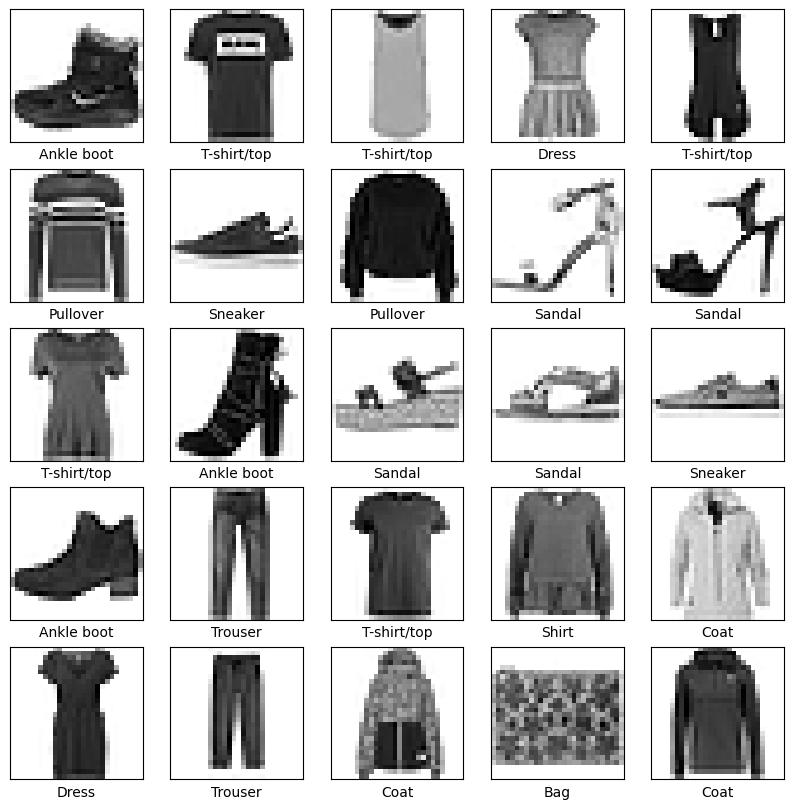

In [173]:
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fm_X_train[i], cmap=plt.cm.binary)
    plt.xlabel(fashion_mnist_class_names[fm_y_train[i]])
plt.show()

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

Flattened and scaled training data shape: (60000, 784)
Flattened and scaled test data shape: (10000, 784)

Training Logistic Regression model for Fashion-MNIST...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training complete.

--- Fashion-MNIST Classification Report ---
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.86      0.85      1000
           4       0.74      0.76      0.75      1000
           5       0.95      0.92      0.93      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Displaying 5 misclassified images:


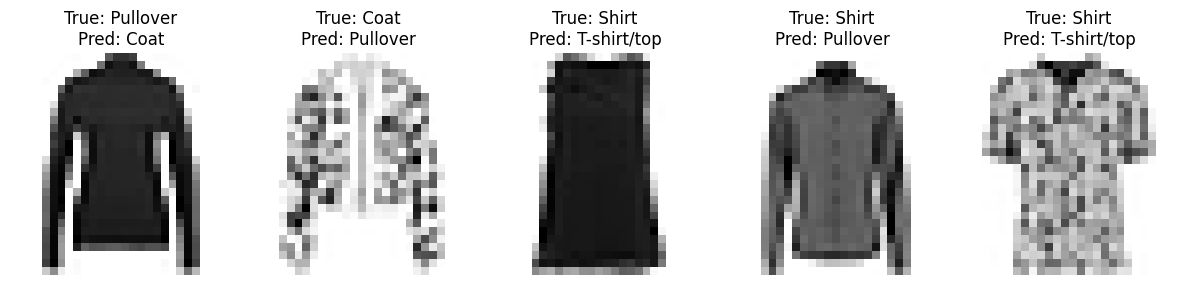

In [130]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---

# 1. Flatten: Convert each 28x28 image into a 1D array of 784 features.
fm_X_train_flattened = fm_X_train.reshape(fm_X_train.shape[0], -1)
fm_X_test_flattened = fm_X_test.reshape(fm_X_test.shape[0], -1)

# 2. Scale: Normalize pixel values from [0, 255] to [0, 1].
fm_X_train_scaled = fm_X_train_flattened / 255.0
fm_X_test_scaled = fm_X_test_flattened / 255.0

print(f"Flattened and scaled training data shape: {fm_X_train_scaled.shape}")
print(f"Flattened and scaled test data shape: {fm_X_test_scaled.shape}")

# 3. Train Logistic Regression:
# Initialize LogisticRegression(solver='saga')
model_fashion = LogisticRegression(solver='saga', max_iter=200, random_state=42) # Increased max_iter for convergence

# Fit the model on your processed fm_X_train_scaled and fm_y_train
print("\nTraining Logistic Regression model for Fashion-MNIST...")
model_fashion.fit(fm_X_train_scaled, fm_y_train)
print("Training complete.")

# 4. Make Predictions:
# Use predict() to make predictions on the processed fm_X_test_scaled
fm_y_pred = model_fashion.predict(fm_X_test_scaled)

# 5. Print Classification Report:
print("\n--- Fashion-MNIST Classification Report ---")
print(classification_report(fm_y_test, fm_y_pred))

# 6. Visualize Misclassifications:
# Find indices where the model made incorrect predictions
misclassified_indices = np.where(fm_y_pred != fm_y_test)[0]

# Select 5 of these misclassified images (if available)
num_misclassified_to_show = min(5, len(misclassified_indices))

if num_misclassified_to_show > 0:
    print(f"\nDisplaying {num_misclassified_to_show} misclassified images:")
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(np.random.choice(misclassified_indices, num_misclassified_to_show, replace=False)):
        plt.subplot(1, num_misclassified_to_show, i + 1)
        plt.imshow(fm_X_test[idx], cmap=plt.cm.binary)
        plt.title(f"True: {fashion_mnist_class_names[fm_y_test[idx]]}\nPred: {fashion_mnist_class_names[fm_y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display (or model is perfect!).")

# --- YOUR CODE FOR EXERCISE 2 ENDS HERE ---

## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [174]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [175]:
# Print the first document and its class
print(f"First document content:\n{X_train_news[0]}\n")
print(f"First document class (index): {y_train_news[0]}")
print(f"First document class name: {news_train.target_names[y_train_news[0]]}")

First document content:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






First document class (index): 7
First document class name: rec.autos


### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [176]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

sample_vec_output_dense = sample_vec_output_sparse.toarray()

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())
print(sample_vec_output_dense)

{'document': 0, 'second': 1}
['document' 'second']
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [177]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---


